 ## Final Assignment Template - Earth Analytics Bootcamp
 
 The assignment repo for this week contains a `README.md` file with 
 instructions to complete your final assignment. Follow those 
 instructions closely!

## Leah Manak's Final! 
In this notebook, there are three figures that show precipitation patterns for Boulder, Co and San Francisco, Ca; the stream flow from four locations throughout Colorado, and an interactive map of the locations of the four stream guages that collected the stream flow in Colorado. In the beginning of the notebook, functions are utilized to download data and generate distinct dataframes. There are short descriptions of each section of the notebook before the code cell, as well as a description of the figures after the figure itself. 

From my knowledge data from this notebook is credited from U.S. National Oceanic and Atmospheric Administration (NOAA), as well as USGS. 

In [300]:
# Core imports needed for grading - DO NOT MODIFY THIS CELL
from glob import glob
import os

import hydrofunctions as hf
import earthpy as et
import seaborn as sns
import pandas as pd
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import folium
import matplotcheck.notebook as nb
from matplotcheck.base import PlotTester
import matplotcheck.autograde as ag
import numpy as np

# We are adding this for you as there is a bug in hydrofunctions that
# Turns off plotting
%matplotlib inline

# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")


## Get set up to complete your assignment
Add cells below to import packages, get data and set your working directory

**IMPORTANT: Be sure to set your working directory to `earth-analytics/data`**

In [301]:
# Import necessary packages
import os
from glob import glob

import hydrofunctions as hf
import earthpy as et
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import folium
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
from shapely.geometry import mapping 
import earthpy.spatial as es
import earthpy.plot as ep
import rasterio as rio

In [302]:
# get data 
file_path = os.path.join(et.io.HOME,
                          'earth-analytics',
                          'data')
file_path

# set working directory and get data

os.chdir(file_path)
file_path
data_url = 'https://ndownloader.figshare.com/files/25564340'
et.data.get_data(url=data_url)

'/Users/leahmanak/earth-analytics/data/earthpy-downloads/boulder-san-fran-precip'

## Define Function 1 - For Figure 1 (10 points)

Create a function that opens up a single `.csv` file containing precipitation data  required  for figure 1
* It should then  subset the data to the year range 1989-2018, summarize the data to 
* Calculate monthly TOTAL (sum) precipitation 
* To simplify your code below, add a new column to your data with the site name 
    * (sf or boulder derived from the file name) 

In [303]:
# In this cell create a function to support figure one

def open_df_daily_to_monthly(file_path):
    """
    Imports a .csv file into a Pandas dataframe, summarizes the data to
    calculate monthly maximum and annual maximum precipitation values, then
    adds a column containing a site name, and indexes the dataframe on the
    new column.
   
    Parameters
    ----------
    file_path : string
        Path to file
       
    year_index : tuple of int
        Index range of year(s)
       
    Returns
    -------
    returned_data : dataframe
        Datraframe created from imported csv file, indexed on a column 'year'
    """
   
    df = pd.read_csv(file_path,
                     index_col='DATE',
                     parse_dates=True)
    # Subset the data from the dates
    df = df['1989-01-01':'2018-12-31']
    # Caclulate the sum for the data
    df = df.resample('MS').sum()
    # Add new column 'months' from the index
    df['months'] = df.index.month
    # Add new column 'year' from index
    df['year'] = df.index.year
    # Add new column 'location' based on the filename
    df['location'] = os.path.basename(file_path.replace(
        '-daily-precip-1948-2018.csv',''))
    return df

## Define Function 2 - For Figure 2

Create a function that takes in a NWIS site number (i.e. '06730500'), a start date, and an end date, and returns a dataframe with the information from the site, including the sites name, latitude, and longitude as columns added into the dataframe hydrofunctions returns.

* Use `hf.NWIS(params)` to get a response from the NWIS website
* Use `response.df()` to get a dataframe from the NWIS response you got
* Use `hf.get_nwis_property(response, property)[0]` to get information about the site you're plotting. `"siteName"` will return the site's name, and `"geoLocation"` will return a dictionary containing the latitude and longitude. Make sure to add the name, latitude, and longitude as new columns in the dataframe for your output!

In [299]:
# In this cell create a function to support figure two 
def create_df(site, start, end):
    """
    Accesses USGS NWIS API to get daily mean stream discharge in cubic
    feet per second (CFS) on user provided site number within specific time
    range. Parses data from API reponse, adds columns to output
    dataframe
   
    Parameters
    ----------
    site : string
        USGS site number
       
    start : string
        Start date in YYYY-MM-DD format
       
    end : string
        End date in YYYY-MM-DD format
       
    Returns
    -------
    df : dataframe
        Datraframe created from API reponse
    """    
   
    # Download the data to the NWIS API
    response = hf.NWIS(site,
                       'dv',
                       start_date=start,
                       end_date=end,
                       parameterCd='00060')
    # Create Dataframe from API response
    df = response.df()
    # Add the initial df column names to the dataframe
    old_names = df.columns.tolist()
    # create the new column names 
    new_names = ['daily_mean_stream_discharge', 'quality_of_measurement']
    # Rename the column names from the old to the new
    df = df.rename(columns=dict(zip(old_names, new_names)))
    # Add columns to the dataframe
    df['siteName'] = hf.get_nwis_property(response.json, key='siteName')[0]
    df['latitude'] = hf.get_nwis_property(
        response.json, key='geoLocation')[0]['geogLocation']['latitude']
    df['longitude'] = hf.get_nwis_property(
        response.json, key='geoLocation')[0]['geogLocation']['longitude']
   
    return df

# Create a variable for the sites, and create a loop in order to call final df
# List of sites
sites = ['06730500', '09105000', '07106300', '07126390']

# Create dataframe with each site through a loop
my_dfs = {}
for site in sites:
    my_dfs[site] = create_df(site, '1990-01-01', '2018-12-31')

#Call one of the dataframes in order to check it. 
#my_dfs['06730500']

Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=06730500&parameterCd=00060&startDT=1990-01-01&endDT=2018-12-31
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=09105000&parameterCd=00060&startDT=1990-01-01&endDT=2018-12-31
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=07106300&parameterCd=00060&startDT=1990-01-01&endDT=2018-12-31
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=07126390&parameterCd=00060&startDT=1990-01-01&endDT=2018-12-31


## Create Dataframes for Figure 1
This cell is the generation of two dataframes needed for figure 1:
1. the Monthly precipitation max
2. the the Annual precipitation max

In [304]:
# Set filepaths in order to access data
boulder_precip_path = os.path.join("earthpy-downloads",
                 "boulder-san-fran-precip",
                 "boulder-daily-precip-1948-2018.csv")
sf_precip_path = os.path.join("earthpy-downloads",
                 "boulder-san-fran-precip",
                 "sf-daily-precip-1948-2018.csv")

# Create dataframes from the file path
boulder_df = open_df_daily_to_monthly(boulder_precip_path)
sf_df = open_df_daily_to_monthly(sf_precip_path)

# Concatenate the sf and boulder dfs
total_precip_df = pd.concat([boulder_df, sf_df])

# Groupby desired columns
monthly_precip_max_df = total_precip_df.groupby(
    ['months', 'location'])[['PRCP']].max()
annual_precip_max_df = total_precip_df.groupby(
    ['year', 'location'])[['PRCP']].max()

#Print the dfs
#annual_precip_max_df
#monthly_precip_max_df


## Code to create Figure 1
This cell contains the code for building a figure that has two subplots:
1. a line graph of the Monthly Maximum Precipitation From 1989 to 2018 for Boulder and San Francisco
2. a line graph of the Total Monthly Maximum Precipitation for Boulder and San Francisco

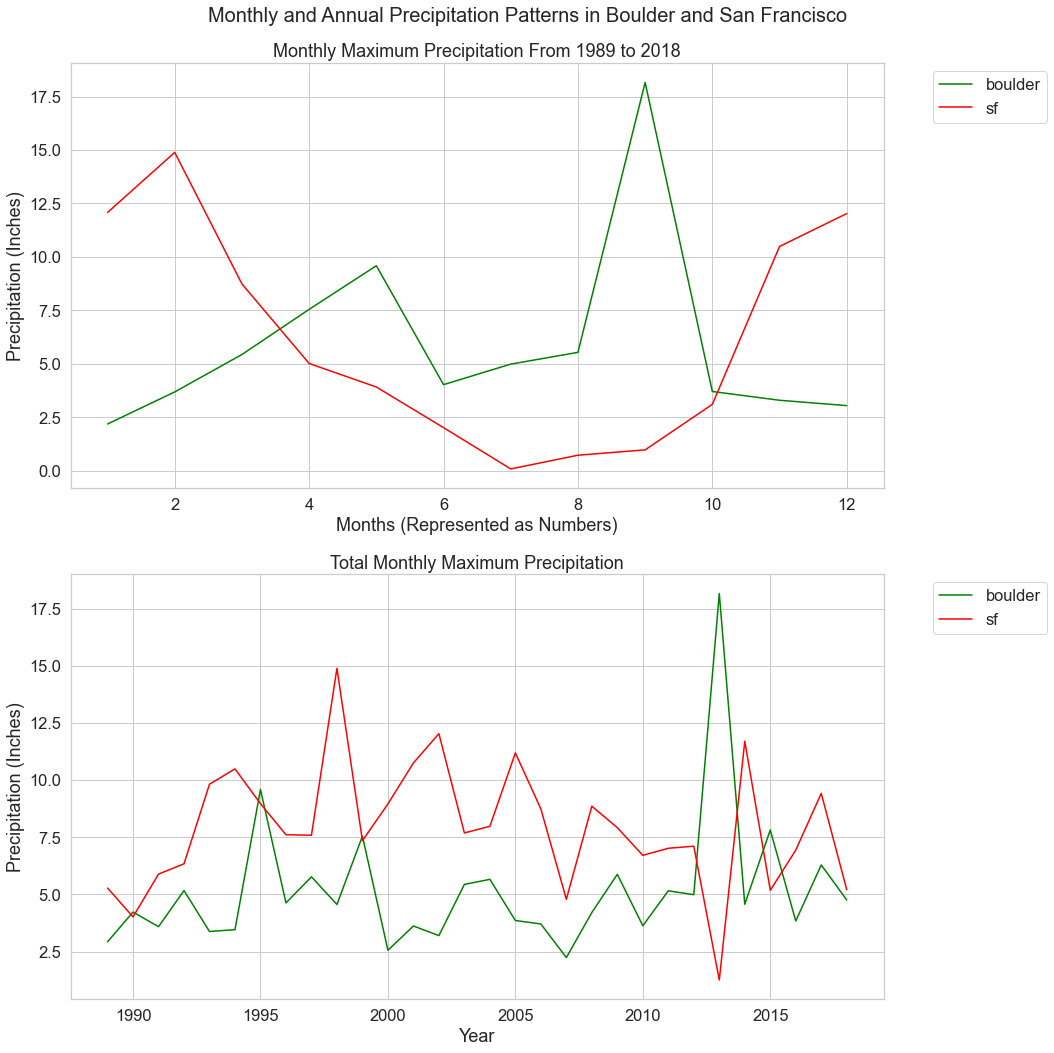

In [307]:
# This is the code for Figure 1:
fig, (ax1, ax2)= plt.subplots(2, 1, figsize = (15,15))

fig.suptitle(
    "Monthly and Annual Precipitation Patterns in Boulder and San Francisco",
    fontsize = 20)

# AX 1 create a for loop for maximum monthly precip values for both locations
for location, month_df in monthly_precip_max_df.groupby("location"):
    if location == 'boulder':
        city = 'boulder'
        color = 'green'
    else: 
        city = 'sf'
        color = 'red'
    ax1.plot(month_df.reset_index().months,
             month_df.PRCP, label=city, color=color)
    ax1.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

# AX 2 create a for loop for maximum monthly precip values for both locations
for location, year_df in annual_precip_max_df.groupby("location"):
    if location == 'sf':
        city = 'sf'
        color = 'red'
    else: 
        city = 'boulder'
        color = 'green'
    ax2.plot(year_df.reset_index().year,
             year_df.PRCP, label=city, color=color)
    ax2.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left') 
    
# Axis Labels
ax1.set(title = 
    "Monthly Maximum Precipitation From 1989 to 2018",
        xlabel = "Months (Represented as Numbers)",
        ylabel = "Precipitation (Inches)");

ax2.set(title = 
    "Total Monthly Maximum Precipitation", 
        xlabel = "Year", 
        ylabel = "Precipitation (Inches)");

plt.tight_layout()

### DO NOT REMOVE LINE BELOW ###
boulder_san_fran_plot = nb.convert_axes(plt, which_axes="all")

## Figure 1 Interpretation:
In this figure, I can see that there are certain variations with the two location's precipitation values. I first noticed on subplot 1 that the two locations show almost an exact inversion of the other. This is telling me that each place was experiencing different weather events in the summer of 2013. I do know that Colorado experiences a monsoon season during that time period, so I am guessing that this is from that. When you zoom out and look at the subplot 2, you can see that there is a mixed pattern of precipitation values for each location. You can point out certain instances where there seems to be a perfect correlation or a perfect inversion. One instance is in year 2003-2004, where it looks like the precipitation values are the opposite. Also in year 2013, we can see an almost perfect inversion as well. 

In [308]:
# DO NOT MODIFY THIS CELL
# Make sure that the cell above this is the cell where you create your plot!

# Tests to ensure your plot is being read by the autograder.

monthly_median = PlotTester(boulder_san_fran_plot[0])
annual_maximum = PlotTester(boulder_san_fran_plot[1])

test_plot_1_top_type = ag.run_test(monthly_median.assert_plot_type,
                                   plot_type="line",
                                   points=0,
                                   correct_message="\u2705 Your top plot is being found by the autograder and is a line plot!",
                                   error_message="\u274C Your top plot is either not being found by the autograder or is not a line plot.")


test_plot_1_bottom_type = ag.run_test(annual_maximum.assert_plot_type,
                                      plot_type="line",
                                      points=0,
                                      correct_message="\u2705 Your bottom plot is being found by the autograder and is a line plot!",
                                      error_message="\u274C Your bottom plot is either not being found by the autograder or is not a line plot.")

print(test_plot_1_top_type["message"])

print(test_plot_1_bottom_type["message"])


✅ Your top plot is being found by the autograder and is a line plot!
✅ Your bottom plot is being found by the autograder and is a line plot!


In [309]:
# DO NOT MODIFY THIS CELL

### Manual Grade for Plot 1

- Plots have appropriate titles
- Plots have appropriate x and y labels
- Each line is a unique color
- Legend has appropriate key words and is displayed correctly

## Figure 2: Stream Discharge For 2013 Colorado Floods

Create a figure containing stream discharge data for the time period:
`start='1990-01-01', end='2018-12-31'` and for the sites `"06730500", "09105000", "07106300", "07126390"`. Automate your workflow
using loops and a function which processes data for each site and adds the data to a DataFrame.
Add as many cells as you want below to process your data.  But be sure to add your plot code to
the cell that says "Add Your Plot Code Here". If the tests checking that your plots are line plots 
don't run, then the autograder won't run either. 

HINT: You can adjust the legend location and font size using:
`plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 11})`

## Generate Dataframes for Figure 2:
The two cells below are to:
1. combine all of the locations to one dataframe, as well as separate the dates to create a dataframe for Aug-Oct 2013
2. calculate the max annual discharge for all of the years from 1989-2018

In [311]:
# concatenate dataframes for plot 1:
dataframes = [my_dfs['06730500'], my_dfs['09105000'],
              my_dfs['07106300'], my_dfs['07126390']]
stream_discharge_all = pd.concat(dataframes)

# get dates from  August 1st, 2013, and October 31st, 2013
discharge_aug_oct = (stream_discharge_all.loc['2013-08-01 00:00:00+00:00':
                                              '2013-10-31 00:00:00+00:00'])
#discharge_aug_oct                                              

In [312]:
# calculate the max annual discharge. 
max_annual_discharge = stream_discharge_all.groupby([
    'siteName', stream_discharge_all.index.year]).max()
#max_annual_discharge

## Code to create Figure 2
This cell contains the code for building a figure that has two subplots:

1. a line graph of the Daily Mean Discharge From August-October 2013 across Colorado.
2. a line graph of the Annual Maximum of Mean Discharge across Colorado.

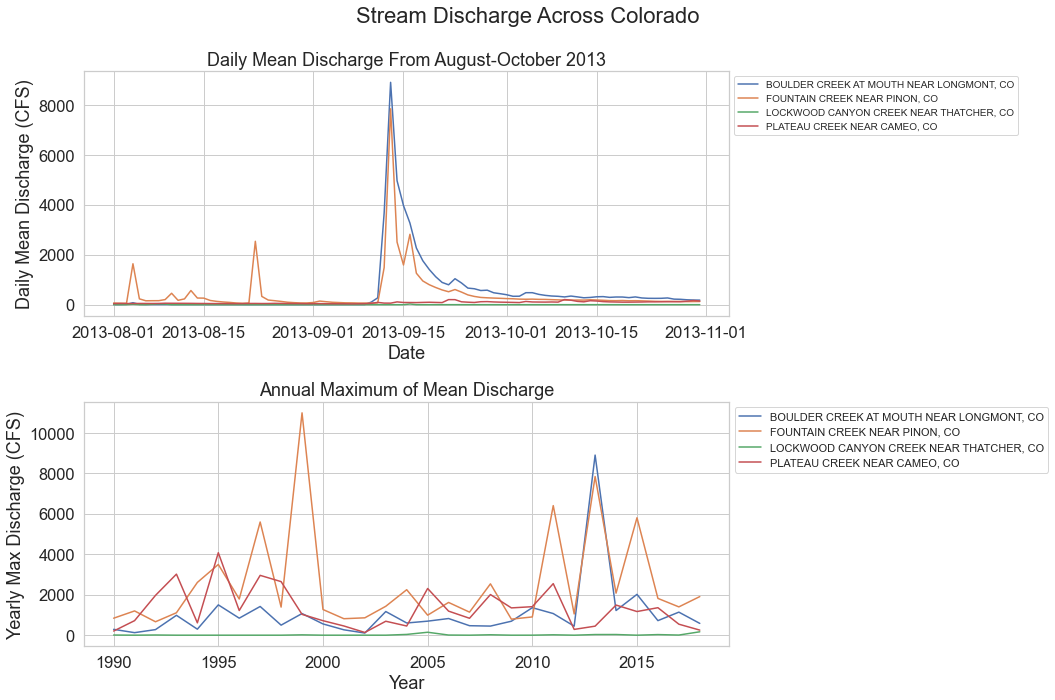

In [313]:
# Set up the figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

fig.suptitle("Stream Discharge Across Colorado", fontsize = 22)

# Create a for loop to define x and y axes for subplot 1
for location, city_df in discharge_aug_oct.reset_index().groupby("siteName"):
    ax1.plot(city_df.datetimeUTC,
             city_df.daily_mean_stream_discharge,
             label = location)
    ax1.legend(bbox_to_anchor=(1, 1.0), loc='upper left', fontsize = 10)

# Set plot title and axes labels for subplot 1
ax1.set(title = "Daily Mean Discharge From August-October 2013",
       xlabel = "Date",
       ylabel = "Daily Mean Discharge (CFS)");

# Create a for loop to define x and y axes for subplot 2
for location, yr_df in max_annual_discharge.reset_index().groupby("siteName"):
    ax2.plot(yr_df.datetimeUTC, 
            yr_df.daily_mean_stream_discharge,
            label = location)
    ax2.legend(bbox_to_anchor=(1, 1.0), loc='upper left', prop={'size': 11})

# Set plot title and axes labels for subplot 2
ax2.set(title = "Annual Maximum of Mean Discharge",
       xlabel = "Year",
       ylabel = "Yearly Max Discharge (CFS)")

plt.tight_layout()

### DO NOT REMOVE LINE BELOW ###
co_streams_plot = nb.convert_axes(plt, which_axes="all")

## Figure 2 Interpretation:
In this figure, I can immediately tell that there are distinguishing values at some of the locations for both plots. In the first subplot, I noticed that both the Boulder Creek, and the Fountain Creek locations show more stream discharge than the other two locations in the year 2013. This makes me think that these locations will have more overall discharge in general, however, when you zoom out and see the whole picture in the second plot of the figure, you can see that this might not be the case. In the second plot, it is evident that the Fountain Creek guage is reading the highest levels, but the Plateau Creek guage is also very active (where in the first plot this didn't seem to be the case). The Lockwood Canyon guage is very low in both plots, showing us that there isn't much discharge in that area. We can also infer that there was a possible drought between the years 2000 and 2010 since all of the guages are reading low. 

In [314]:
# DO NOT MODIFY THIS CELL

daily_mean = PlotTester(co_streams_plot[0])
annual_maximum_2 = PlotTester(co_streams_plot[1])

test_plot_2_top_type = ag.run_test(daily_mean.assert_plot_type,
                                   plot_type="line",
                                   points=0,
                                   correct_message="\u2705 Your top plot is being found by the autograder and is a line plot!",
                                   error_message="\u274C Your top plot is either not being found by the autograder or is not a line plot.")


test_plot_2_bottom_type = ag.run_test(annual_maximum_2.assert_plot_type,
                                      plot_type="line",
                                      points=0,
                                      correct_message="\u2705 Your bottom plot is being found by the autograder and is a line plot!",
                                      error_message="\u274C Your bottom plot is either not being found by the autograder or is not a line plot.")

print(test_plot_2_top_type["message"])

print(test_plot_2_bottom_type["message"])


✅ Your top plot is being found by the autograder and is a line plot!
✅ Your bottom plot is being found by the autograder and is a line plot!


In [315]:
# DO NOT MODIFY THIS CELL

### Manual Grading for Plot 2

- Plots have appropriate titles
- Plots have appropriate x and y labels
- Each line is a unique color
- Legend has appropriate key words and is displayed correctly

## Figure 3: Stream Gage Locations Interactive Map

Create an interactive `folium` that shows the 4 stream gage locations that 
you downloaded data for above. BONUS: Add a popup to the map with the 
gage site name in it.

You can use the code below to get a start on creating the interactive map.

```
m = folium.Map(location=[39.0150, -105.2705],
               tiles='Stamen Terrain',
               zoom_start=7)


for name, xy in gages_dataframe_name_here.groupby(["name_column"]):
    folium.Marker(
        location=[xy.lat[0], xy.long[0]],
        popup=name, 
        icon=folium.Icon()
    ).add_to(m)
```

In [243]:

# Add your code to create a folium map here
m = folium.Map(location=[39.0150, -105.2705],
               tiles='Stamen Toner',
               zoom_start=7)
#40.13877, -105.020222

for name, xy in discharge_aug_oct.groupby(["siteName"]):
    folium.Marker(
        location=[xy.latitude[0], xy.longitude[[0]]],
        popup=name, 
        icon=folium.Icon(color='lightblue', 
                         icon_color='blue',
                         icon='glyphicon-tint')
    ).add_to(m)

m


# Figure 3 Interpretation:
This figure shows the three locations where stream guages collected the data that we used above. Based on the map, I can see why the Lockwood Canyon location get less discharge. From my knowledge of growing up in Montrose, Colorado I know that on the SE side of the state, there are typically dryer conditions. I would assume that there is a greater discharge in the other three sites due to being more in the mountaneous region of the state! This map is really cool!

## Manual Grade: Folium Stream Gage Location Plot

* Interactive folium map is created above with a basemap of the students choice (10 points)
* Plot contains 4 stream gage locations in the correct place (10 points)
* BONUS: Plot contains a popup box with the site name in it (5 points)

NOTE: just in case you were wondering... the USGS  does spell stream gage (**gage** not **guage**).
We follow their spelling lead in our assignments and lessons.

## Manual Grade: Clean Code Requirements (30 points)
In this cell, we will give you points for the following

* Notebook uses loops and functions to make code more efficient and clean
  * Notebook uses loops to plot rather than manually creating each axis 
* Notebook uses DRY approaches (don't repeat yourself) to avoid "copy pasta" style repetitive code


## Manual Grade: Markdown Cells Are Used to Organization Code

* Markdown cells are used to organize code (5)
* Patterns observed in each figure are described in a markdown cell below that figure (15)

## Manual Grade: Pep 8, Spelling and Does the Notebook Run?
In this cell, we will give you points for the following

1. PEP 8 is followed throughout the notebook 
2. Spelling and grammar are considered in your written responses above
3. The notebook runs from top to bottom without any editing (it is reproducible)